<a href="https://colab.research.google.com/github/Geolist/first-repository/blob/main/%EB%89%B4%EC%8A%A4_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신러닝에서 젤 좋은 모델은 XGBoost

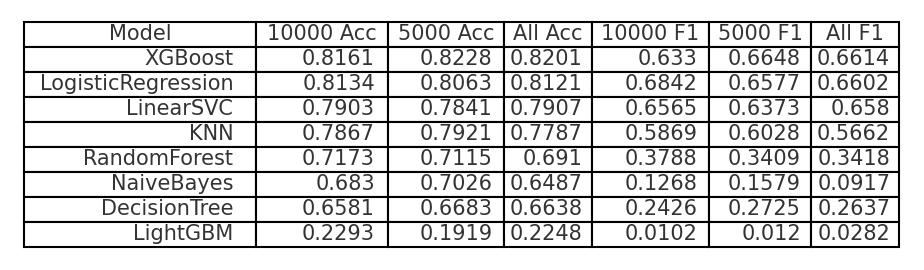

# W2VEC 젤 좋은 모델은 RNN 이었다

| 모델          | Accuracy   | F1-Score (macro) | 해석                                  |
| ----------- | ---------- | ---------------- | ----------------------------------- |
| **Bi-LSTM** | **0.7818** | **0.3706**       | 문장 순서를 반영하는 RNN 계열로 가장 우수한 성능       |
| XGBoost     | 0.7275     | 0.3333           | 전통 ML 알고리즘이지만 평균 벡터 정보로도 일정 성능      |
| Dense NN    | 0.6817     | 0.2032           | 순서 정보 없이 단순 Flatten → DNN 구조는 약간 저조 |



In [2]:
!pip install lightgbm xgboost -q
!pip install gensim

In [3]:
# 라이브러리
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import DMatrix, train as xgb_train
from lightgbm import LGBMClassifier
import pandas as pd, numpy as np, time, warnings, gc
from tqdm import tqdm

warnings.filterwarnings("ignore")


In [4]:
# 실험용 단어장 크기 세트
vocab_sizes = [10000, 5000, None]  # None은 전체 단어 사용

In [5]:
# 결과 저장용
results = []

In [6]:
# 모델 구성 (하이퍼파라미터 반영)
models = {
    "LogisticRegression": LogisticRegression(C=10000, penalty='l2', max_iter=3000, n_jobs=-1),
    "LinearSVC": LinearSVC(C=1000, penalty='l2', max_iter=1000, dual=True),
    "RandomForest": RandomForestClassifier(n_estimators=5, random_state=0),
    "XGBoost": dict(max_depth=6, eta=0.1, objective="multi:softprob",
                    num_class=46, tree_method="gpu_hist",
                    predictor="gpu_predictor", eval_metric="mlogloss"),
    "NaiveBayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
    "LightGBM": LGBMClassifier(objective='multiclass', num_class=46,
                               n_estimators=200, learning_rate=0.1, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(max_depth=15, random_state=42)
}


In [7]:
# 3. 단어장 크기별 실험 루프

for vocab_size in vocab_sizes:
    label = vocab_size or "All"
    print(f"\n================  Vocab = {label}  ================\n")

    # 1) 데이터 로딩
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)
    word_index = reuters.get_word_index()
    index_to_word = {i + 3: word for word, i in word_index.items()}
    index_to_word.update({0: "<PAD>", 1: "<SOS>", 2: "<UNK>"})

    x_train_txt = [" ".join(index_to_word.get(i, "?") for i in seq) for seq in x_train]
    x_test_txt  = [" ".join(index_to_word.get(i, "?") for i in seq) for seq in x_test]

    # 2) TF-IDF 벡터화
    vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english')
    tfidf = TfidfTransformer()

    X_train = tfidf.fit_transform(vectorizer.fit_transform(x_train_txt))
    X_test  = tfidf.transform(vectorizer.transform(x_test_txt))

    # 3) 차원 축소 조건부 적용
    if X_train.shape[1] > 50000:
        print(f"⚠️ 차원 축소 적용: {X_train.shape[1]} → 1000")
        svd = TruncatedSVD(n_components=1000, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_test  = svd.transform(X_test)

    # 4) 모델 루프
    for model_name in tqdm(models, desc=f"Vocab={label}"):
        t0 = time.time()

        if model_name == "XGBoost":
            dtrain = DMatrix(X_train, label=y_train)
            dtest  = DMatrix(X_test, label=y_test)
            booster = xgb_train(models["XGBoost"], dtrain,
                                num_boost_round=150,
                                evals=[(dtest, "test")],
                                early_stopping_rounds=20,
                                verbose_eval=False)
            y_pred = booster.predict(dtest).argmax(1)

        elif model_name == "LightGBM":
            model = models["LightGBM"]
            try:
                model.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          callbacks=[early_stopping(20), log_evaluation(0)])
            except:
                model.fit(X_train, y_train)  # fallback for older versions
            y_pred = model.predict(X_test)

        else:
            model = models[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc = round(accuracy_score(y_test, y_pred), 4)
        f1  = round(f1_score(y_test, y_pred, average='macro'), 4)

        results.append({
            "Vocabulary Size": str(label),
            "Model": model_name,
            "Accuracy": acc,
            "F1-Score": f1,
            "Time": round(time.time()-t0, 2)
        })

        print(f"⏱ {model_name:18s} | Acc {acc:.4f} | F1 {f1:.4f} | {time.time()-t0:.2f}s")
        gc.collect()


================  Vocab = 10000  ================



Vocab=10000:  12%|█▎        | 1/8 [00:10<01:14, 10.58s/it]

⏱ LogisticRegression | Acc 0.8134 | F1 0.6842 | 10.34s


Vocab=10000:  25%|██▌       | 2/8 [00:20<00:59,  9.90s/it]

⏱ LinearSVC          | Acc 0.7734 | F1 0.6337 | 9.19s


Vocab=10000:  38%|███▊      | 3/8 [00:22<00:31,  6.35s/it]

⏱ RandomForest       | Acc 0.7173 | F1 0.3788 | 1.88s


Vocab=10000:  50%|█████     | 4/8 [01:21<01:49, 27.45s/it]

⏱ XGBoost            | Acc 0.8161 | F1 0.6330 | 59.54s
⏱ NaiveBayes         | Acc 0.6830 | F1 0.1268 | 0.04s


Vocab=10000:  75%|███████▌  | 6/8 [01:23<00:24, 12.23s/it]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Vocab=10000:  88%|████████▊ | 7/8 [02:44<00:34, 34.60s/it]

⏱ LightGBM           | Acc 0.3491 | F1 0.0116 | 80.41s


Vocab=10000: 100%|██████████| 8/8 [02:46<00:00, 20.85s/it]

⏱ DecisionTree       | Acc 0.6581 | F1 0.2426 | 1.96s

================  Vocab = 5000  ================




Vocab=5000:  12%|█▎        | 1/8 [00:08<01:01,  8.81s/it]

⏱ LogisticRegression | Acc 0.8063 | F1 0.6577 | 8.55s


Vocab=5000:  25%|██▌       | 2/8 [00:15<00:45,  7.59s/it]

⏱ LinearSVC          | Acc 0.7850 | F1 0.6424 | 6.49s


Vocab=5000:  38%|███▊      | 3/8 [00:17<00:24,  4.94s/it]

⏱ RandomForest       | Acc 0.7115 | F1 0.3409 | 1.47s


Vocab=5000:  50%|█████     | 4/8 [01:05<01:28, 22.07s/it]

⏱ XGBoost            | Acc 0.8228 | F1 0.6648 | 48.04s
⏱ NaiveBayes         | Acc 0.7026 | F1 0.1579 | 0.04s


Vocab=5000:  75%|███████▌  | 6/8 [01:08<00:20, 10.13s/it]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Vocab=5000:  88%|████████▊ | 7/8 [02:25<00:32, 32.03s/it]

⏱ LightGBM           | Acc 0.1919 | F1 0.0120 | 76.86s


Vocab=5000: 100%|██████████| 8/8 [02:27<00:00, 18.41s/it]

⏱ DecisionTree       | Acc 0.6683 | F1 0.2725 | 1.77s

================  Vocab = All  ================




Vocab=All:  12%|█▎        | 1/8 [00:22<02:37, 22.56s/it]

⏱ LogisticRegression | Acc 0.8121 | F1 0.6602 | 22.32s


Vocab=All:  25%|██▌       | 2/8 [00:33<01:34, 15.80s/it]

⏱ LinearSVC          | Acc 0.8014 | F1 0.6603 | 10.83s


Vocab=All:  38%|███▊      | 3/8 [00:37<00:51, 10.26s/it]

⏱ RandomForest       | Acc 0.6910 | F1 0.3418 | 3.43s


Vocab=All:  50%|█████     | 4/8 [02:11<02:53, 43.33s/it]

⏱ XGBoost            | Acc 0.8201 | F1 0.6614 | 93.76s
⏱ NaiveBayes         | Acc 0.6487 | F1 0.0917 | 0.07s


Vocab=All:  75%|███████▌  | 6/8 [02:13<00:37, 18.91s/it]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Vocab=All:  88%|████████▊ | 7/8 [03:32<00:38, 38.61s/it]

⏱ DecisionTree       | Acc 0.6638 | F1 0.2637 | 2.83s


Vocab=All: 100%|██████████| 8/8 [03:35<00:00, 26.95s/it]


In [8]:
# 4. 결과 표

df_result = pd.DataFrame(results)
pivot = df_result.pivot(index='Model', columns='Vocabulary Size', values=['Accuracy', 'F1-Score'])

print("\n✅ [최종 성능 요약 표]")
display(pivot)

# 결과 저장 필요 시
# df_result.to_csv("reuters_model_results.csv", index=False)


✅ [최종 성능 요약 표]


Accuracy                 F1-Score                
Vocabulary Size       10000    5000     All    10000    5000     All
Model                                                               
DecisionTree         0.6581  0.6683  0.6638   0.2426  0.2725  0.2637
KNN                  0.7867  0.7921  0.7787   0.5869  0.6028  0.5662
LightGBM             0.3491  0.1919  0.2248   0.0116  0.0120  0.0282
LinearSVC            0.7734  0.7850  0.8014   0.6337  0.6424  0.6603
LogisticRegression   0.8134  0.8063  0.8121   0.6842  0.6577  0.6602
NaiveBayes           0.6830  0.7026  0.6487   0.1268  0.1579  0.0917
RandomForest         0.7173  0.7115  0.6910   0.3788  0.3409  0.3418
XGBoost              0.8161  0.8228  0.8201   0.6330  0.6648  0.6614

In [11]:
# Word2Vec 기반 딥러닝 및 ML 모델 평가 전체 코드 (불필요한 부분 제거, 정리된 버전)
!pip install -q gensim xgboost tensorflow

import numpy as np, pandas as pd, warnings, gc, time
from gensim.models import Word2Vec
from tensorflow.keras.datasets import reuters
from tensorflow.keras import layers, models, Sequential
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

In [12]:
# 1) 데이터 로드 + 토큰화
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
idx2word = {i+3:w for w,i in reuters.get_word_index().items()}
idx2word.update({0:"<PAD>",1:"<SOS>",2:"<UNK>"})
train_tok = [[idx2word.get(i,"?") for i in seq] for seq in x_train]
test_tok  = [[idx2word.get(i,"?") for i in seq] for seq in x_test]

In [13]:
# 3) 문장 길이 & max_len
max_len = int(np.percentile([len(s) for s in train_tok], 90))
print(f"max_len(90%) = {max_len}")

max_len(90%) = 313


In [14]:
# 4) Word2Vec 학습
# ─────────────────────────────────────────────
w2v = Word2Vec(sentences=train_tok, vector_size=256, window=5,
               min_count=5, workers=4, sg=0)
vec_dim = w2v.vector_size
print("✅ Word2Vec 학습 완료")

✅ Word2Vec 학습 완료


In [15]:
# 5) 시퀀스/평균 벡터 생성 (post-padding, float16)
# ─────────────────────────────────────────────
def sent2mat(tokens, model, max_len):
    vecs = [model.wv[w] if w in model.wv else np.zeros(vec_dim, "float16")
            for w in tokens[:max_len]]
    if len(vecs) < max_len:                     # post padding
        vecs += [np.zeros(vec_dim, "float16")] * (max_len - len(vecs))
    return np.vstack(vecs, dtype="float16")

X_train_seq = np.array([sent2mat(s, w2v, max_len) for s in train_tok], dtype="float16")
X_test_seq  = np.array([sent2mat(s, w2v, max_len) for s in test_tok],  dtype="float16")

X_train_avg = X_train_seq.mean(axis=1).astype("float16")
X_test_avg  = X_test_seq.mean(axis=1).astype("float16")

In [16]:
# 6-A) XGBoost (평균 벡터)
# ─────────────────────────────────────────────
xgb = XGBClassifier(n_estimators=100, max_depth=5,
                    objective="multi:softprob", num_class=46,
                    eval_metric="mlogloss", tree_method="hist", n_jobs=-1)
xgb.fit(X_train_avg, y_train)
pred_xgb = xgb.predict(X_test_avg)

In [18]:
# 6-B) Dense NN (Flatten + 전결합)
# ─────────────────────────────────────────────
dense = Sequential([
    layers.Flatten(input_shape=(max_len, vec_dim)),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(46, activation="softmax")
])
dense.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
dense.fit(X_train_seq, y_train, validation_split=0.1,
          epochs=10, batch_size=32, verbose=0)
pred_dense = dense.predict(X_test_seq).argmax(1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [17]:
# 6-C) Bi-LSTM (시퀀스)
# ─────────────────────────────────────────────
rnn = Sequential([
    layers.Input(shape=(max_len, vec_dim)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(46, activation="softmax")
])
rnn.compile(optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
rnn.fit(X_train_seq, y_train, validation_split=0.1,
        epochs=10, batch_size=32, verbose=0)
pred_rnn = rnn.predict(X_test_seq).argmax(1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [19]:
# 7) 결과 집계
# ─────────────────────────────────────────────
results_w2v = pd.DataFrame({
    "Vectorization":["Word2Vec"]*3,
    "Model":["XGBoost","Dense NN","Bi-LSTM"],
    "Accuracy":[accuracy_score(y_test,p) for p in [pred_xgb,pred_dense,pred_rnn]],
    "F1-Score":[f1_score(y_test,p,average="macro") for p in [pred_xgb,pred_dense,pred_rnn]]
}).round(4)

print("\n📊 Word2Vec 기반 모델 성능 요약")
print(results_w2v.to_string(index=False))


📊 Word2Vec 기반 모델 성능 요약
Vectorization    Model  Accuracy  F1-Score
     Word2Vec  XGBoost    0.7275    0.3333
     Word2Vec Dense NN    0.6817    0.2032
     Word2Vec  Bi-LSTM    0.7818    0.3706
